## MARKOV DECISION PROCESSES & REINFORCEMENT LEARNING

### FROZEN LAKE MDP APPROACH

In [1]:
import gym
import numpy as np
import random
from timeit import default_timer as timer
from datetime import timedelta
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns

In [2]:
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
np.random.seed(2)
sixteen = generate_random_map(16)
np.random.seed(44)
tvelve = generate_random_map(12)
MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
    "12x12": tvelve,
    "16x16": sixteen
}

In [3]:
def test_policy(env, policy, n_epoch=1000):
    rewards = []
    episode_counts = []
    for i in range(n_epoch):
        current_state = env.reset()
        ep = 0
        done = False
        episode_reward = 0
        while not done and ep < 1000:
            ep += 1
            act = int(policy[current_state])
            new_state, reward, done, _ = env.step(act)
            episode_reward += reward
            current_state = new_state
            
        rewards.append(episode_reward)
        episode_counts.append(ep)
    
    # all done
    mean_reward = sum(rewards)/len(rewards)
    mean_eps = sum(episode_counts)/len(episode_counts)
    return mean_reward, mean_eps, rewards, episode_counts 

In [4]:
def value_iteration(env, discount=0.9, epsilon=1e-12):
    
    start = timer()
    
    number_of_states = env.observation_space.n
    number_of_actions = env.action_space.n
    policy = np.zeros((1, number_of_states))
    value_list = np.zeros((1, number_of_states))
    old_value_list = value_list.copy()
    episode = 0
    max_change = 1
    sigma = discount
    while max_change > epsilon:
        episode += 1
        for s in range(number_of_states):
            assigned_value = -np.inf
            for a in range(number_of_actions):
                # get new state and its reward        
                total_cand_value = 0
                for prob, new_state, reward, done in env.P[s][a]:
                    # get new states value
                    value_new_state = old_value_list[0][new_state]
                    cand_value = 0
                    if done:
                        cand_value = reward 
                    else:
                        cand_value = reward + sigma*value_new_state
                    total_cand_value += cand_value*prob 
                        
                if total_cand_value > assigned_value:
                    assigned_value = total_cand_value
                    policy[0][s] = a
                    value_list[0][s] = assigned_value
        changes = np.abs(value_list - old_value_list)
        max_change = np.max(changes)
        old_value_list = value_list.copy()
        
    end = timer()
    time_spent = timedelta(seconds=end-start)
    print("Solved in: {} episodes and {} seconds".format(episode, time_spent))
    return policy[0], episode, time_spent

In [5]:
def policy_iteration(env, discount=0.9, epsilon=1e-3):
    
    start = timer()
    
    number_of_states = env.observation_space.n
    number_of_actions = env.action_space.n
    ## 1
    policy = np.random.randint(number_of_actions, size=(1,number_of_states))
#     policy = np.zeros((1,number_of_states))
    value_list = np.zeros((1, number_of_states))
    episode = 0
    sigma = discount
    
    ## 2
    policy_stable = False
    while not policy_stable:
        episode += 1
        eval_acc = True
        while eval_acc:
            eps = 0
            for s in range(number_of_states):
                # first row
                v = value_list[0][s]

                # get the new value 
                a = policy[0][s]
                total_val_new_state = 0
                for prob, new_state, reward, done in env.P[s][a]:
                    value_new_state = value_list[0][new_state]
                    # second row
                    cand_value = 0
                    if done:
                        cand_value = reward                     
                    else:
                        cand_value = reward + sigma*value_new_state
                    total_val_new_state += cand_value*prob 
                value_list[0][s] = total_val_new_state
                    
                # third row
                eps = max(eps, np.abs(v-value_list[0][s]))
            if eps < epsilon:
                eval_acc = False


        ## 3
        policy_stable = True
        for s in range(number_of_states):

            # assign 
            old_action = policy[0][s]
            # get the argmax a here
            max_value = -np.inf
            for a in range(number_of_actions):
                # get the new value 
                total_cand_value = 0
                for prob, new_state, reward, done in env.P[s][a]:
                    value_new_state = value_list[0][new_state]
                    cand_value = 0
                    if done:
                        cand_value = reward
                    else:
                        cand_value = reward + sigma*value_new_state
                    total_cand_value += prob*cand_value
                if total_cand_value > max_value:
                    max_value = total_cand_value
                    policy[0][s] = a

            # if old-action != policy[s]
            if old_action != policy[0][s]:
                policy_stable = False
    
    
    end = timer()
    time_spent = timedelta(seconds=end-start)
    print("Solved in: {} episodes and {} seconds".format(episode, time_spent))
    return policy[0], episode, time_spent
        

In [6]:
def train_and_test_pi_vi(env, discount=[0.9], epsilon=[1e-9], mute=False):
    
    vi_dict = {}
    
    for dis in discount:
        vi_dict[dis] = {}
        for eps in epsilon:
            vi_dict[dis][eps] = {}
            
            # run value iteration
            vi_policy, vi_solve_iter, vi_solve_time = value_iteration(env, dis, eps)
            vi_mrews, vi_meps, _, __ = test_policy(env, vi_policy)    
            vi_dict[dis][eps]["mean_reward"] = vi_mrews
            vi_dict[dis][eps]["mean_eps"] = vi_meps
            vi_dict[dis][eps]["iteration"] = vi_solve_iter
            vi_dict[dis][eps]["time_spent"] = vi_solve_time
            vi_dict[dis][eps]["policy"] = vi_policy
            if not mute:
                print("Value iteration for {} discount and {} eps is done".format(dis, eps))
                print("Iteration: {} time: {}".format(vi_solve_iter, vi_solve_time))
                print("Mean reward: {} - mean eps: {}".format(vi_mrews, vi_meps))
    # run policy iteration
    pi_dict = {}
    for dis in discount:
        pi_dict[dis] = {}
        for eps in epsilon:
            pi_dict[dis][eps] = {}

            pi_policy, pi_solve_iter, pi_solve_time = policy_iteration(env, dis, eps)
            pi_mrews, pi_meps, _, __ = test_policy(env, pi_policy)    
            pi_dict[dis][eps]["mean_reward"] = pi_mrews
            pi_dict[dis][eps]["mean_eps"] = pi_meps
            pi_dict[dis][eps]["iteration"] = pi_solve_iter
            pi_dict[dis][eps]["time_spent"] = pi_solve_time
            pi_dict[dis][eps]["policy"] = pi_policy
            if not mute:
                print("Policy iteration for {} discount is done".format(dis))
                print("Iteration: {} time: {}".format(pi_solve_iter, pi_solve_time))
                print("Mean reward: {} - mean eps: {}".format(pi_mrews, pi_meps))

    
    return vi_dict, pi_dict

In [7]:
def map_discretize(the_map):
    size = len(the_map)
    dis_map = np.zeros((size,size))
    for i, row in enumerate(the_map):
        for j, loc in enumerate(row):
            if loc == "S":
                dis_map[i, j] = 0
            elif loc == "F":
                dis_map[i, j] = 0
            elif loc == "H":
                dis_map[i, j] = -1
            elif loc == "G":
                dis_map[i, j] = 1
    return dis_map


def policy_numpy(policy):
    size = int(np.sqrt(len(policy)))
    pol = np.asarray(policy)
    pol = pol.reshape((size, size))
    return pol


def see_policy(map_size, policy):
    map_name = str(map_size)+"x"+str(map_size)
    data = map_discretize(MAPS[map_name])
    np_pol = policy_numpy(policy)
    plt.imshow(data, interpolation="nearest")

    for i in range(np_pol[0].size):
        for j in range(np_pol[0].size):
            arrow = '\u2190'
            if np_pol[i, j] == 1:
                arrow = '\u2193'
            elif np_pol[i, j] == 2:
                arrow = '\u2192'
            elif np_pol[i, j] == 3:
                arrow = '\u2191'
            text = plt.text(j, i, arrow,
                           ha="center", va="center", color="w")
    plt.show()


In [8]:
def plot_the_dict(dictionary, value="Score", size=4, variable="Discount Rate", log=False):

    plt.figure(figsize=(12, 8))
    title = "Average and Max {} on {}x{} Frozen Lake".format(value, size, size)
    the_val = value
    value = "Average {}".format(the_val)
    val_type = "Type of {}".format(the_val)
    the_df = pd.DataFrame(columns=[variable, value, val_type])
    for k, v in dictionary.items():
        for val in v:
            if not log:
                dic = {variable: k, value: float(val), val_type: "Average with std"}
            else:
                dic = {variable: np.log10(k), value: float(val), val_type: "Average with std"}                
            the_df = the_df.append(dic, ignore_index=True)
        if not log:
            dic = {variable: k, value: float(max(v)), val_type: "Max"}
        else:
            dic = {variable: np.log10(k), value: float(max(v)), val_type: "Max"}
        the_df = the_df.append(dic, ignore_index=True)
    sns.lineplot(x=variable, y=value, hue=val_type, style=val_type, markers=True, data=the_df).set(title=title)

In [9]:
def convert_dict_to_dict(the_dict):
    
    # return for discount
    discount_rewards = {}
    discount_iterations = {}
    discount_times = {}


    for disc in the_dict:
        discount_rewards[disc] = []    
        discount_iterations[disc] = []    
        discount_times[disc] = []

        for eps in the_dict[disc]:
            discount_rewards[disc].append(the_dict[disc][eps]['mean_reward'])
            discount_iterations[disc].append(the_dict[disc][eps]['iteration'])        
            discount_times[disc].append(the_dict[disc][eps]['time_spent'].total_seconds())  

            
    epsilon_rewards = {}
    epsilon_iterations = {}
    epsilon_times = {}
    for eps in the_dict[0.5]:
        epsilon_rewards[eps] = []    
        epsilon_iterations[eps] = []    
        epsilon_times[eps] = []
    
        for disc in vi_dict:
            epsilon_rewards[eps].append(the_dict[disc][eps]['mean_reward'])
            epsilon_iterations[eps].append(the_dict[disc][eps]['iteration'])        
            epsilon_times[eps].append(the_dict[disc][eps]['time_spent'].total_seconds()) 
            
    return discount_rewards, discount_iterations, discount_times, epsilon_rewards, epsilon_iterations, epsilon_times

## 4x4

In [10]:
env = gym.make("FrozenLake-v1")
vi_dict, pi_dict = train_and_test_pi_vi(env, discount=[0.5, 0.75, 0.9, 0.95, 0.99, 0.9999], 
                                        epsilon=[1e-3, 1e-6, 1e-9, 1e-12, 1e-15], mute=True)

Solved in: 7 episodes and 0:00:00.001932 seconds
Solved in: 16 episodes and 0:00:00.002813 seconds
Solved in: 25 episodes and 0:00:00.004713 seconds
Solved in: 34 episodes and 0:00:00.005822 seconds
Solved in: 44 episodes and 0:00:00.007938 seconds
Solved in: 12 episodes and 0:00:00.002062 seconds
Solved in: 33 episodes and 0:00:00.005981 seconds
Solved in: 53 episodes and 0:00:00.010040 seconds
Solved in: 73 episodes and 0:00:00.012803 seconds
Solved in: 94 episodes and 0:00:00.017049 seconds
Solved in: 27 episodes and 0:00:00.004774 seconds
Solved in: 78 episodes and 0:00:00.013923 seconds
Solved in: 129 episodes and 0:00:00.022552 seconds
Solved in: 179 episodes and 0:00:00.032062 seconds
Solved in: 230 episodes and 0:00:00.040643 seconds
Solved in: 44 episodes and 0:00:00.008052 seconds
Solved in: 128 episodes and 0:00:00.023040 seconds
Solved in: 213 episodes and 0:00:00.036730 seconds
Solved in: 297 episodes and 0:00:00.049802 seconds
Solved in: 381 episodes and 0:00:00.065523 se

In [12]:
pi_dict[0.9999]

{0.001: {'mean_reward': 0.758,
  'mean_eps': 45.016,
  'iteration': 7,
  'time_spent': datetime.timedelta(microseconds=20905),
  'policy': array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])},
 1e-06: {'mean_reward': 0.751,
  'mean_eps': 45.874,
  'iteration': 3,
  'time_spent': datetime.timedelta(microseconds=44791),
  'policy': array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])},
 1e-09: {'mean_reward': 0.749,
  'mean_eps': 44.98,
  'iteration': 4,
  'time_spent': datetime.timedelta(microseconds=100015),
  'policy': array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])},
 1e-12: {'mean_reward': 0.764,
  'mean_eps': 43.657,
  'iteration': 4,
  'time_spent': datetime.timedelta(microseconds=154804),
  'policy': array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])},
 1e-15: {'mean_reward': 0.747,
  'mean_eps': 44.774,
  'iteration': 4,
  'time_spent': datetime.timedelta(microseconds=170859),
  'policy': array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])}}

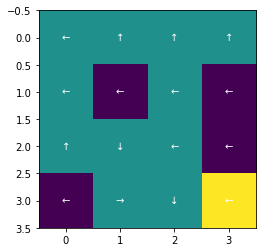

In [13]:
pol = vi_dict[0.99][1e-12]['policy']
vi4 = convert_dict_to_dict(vi_dict)
see_policy(4, pol)

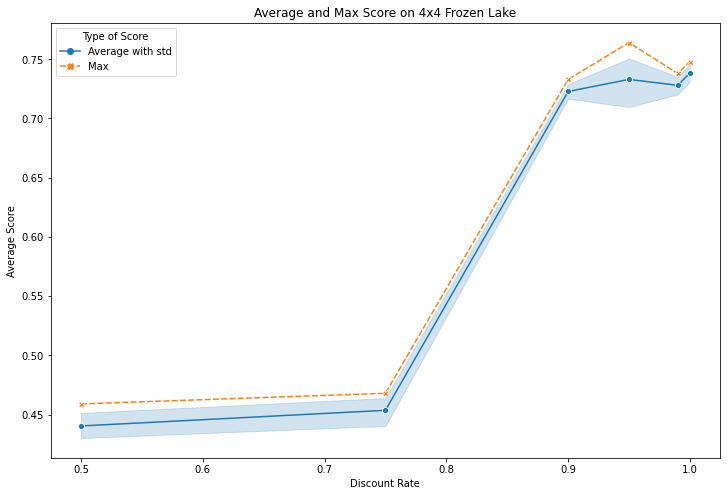

In [14]:
plot_the_dict(vi4[0], value="Score", size=4)

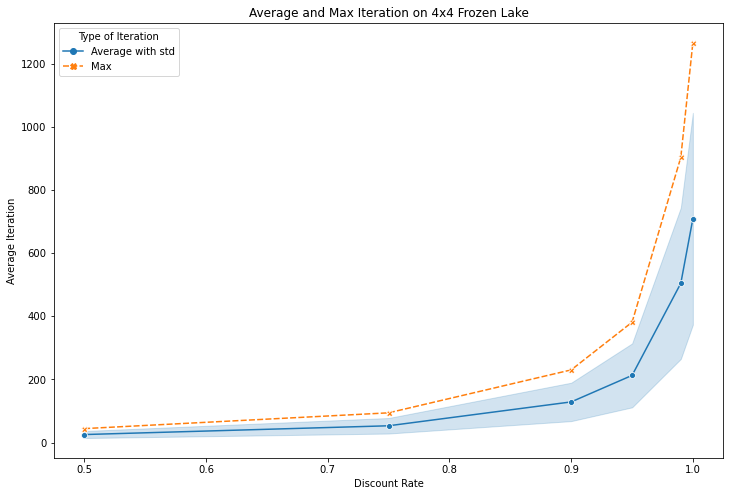

In [15]:
plot_the_dict(vi4[1], value="Iteration", size=4)

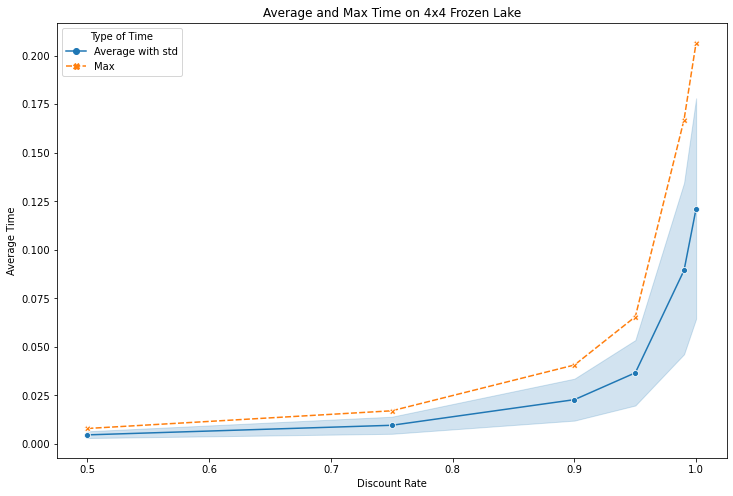

In [16]:
plot_the_dict(vi4[2], value="Time", size=4)

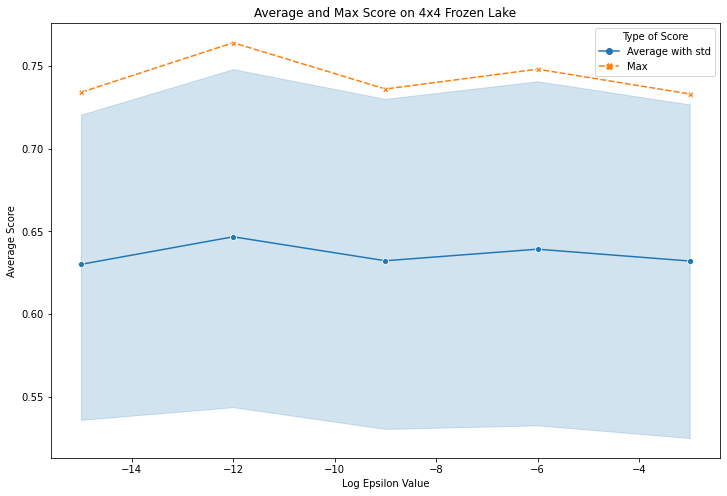

In [17]:
plot_the_dict(vi4[3], value="Score", size=4, variable="Log Epsilon Value", log=True)

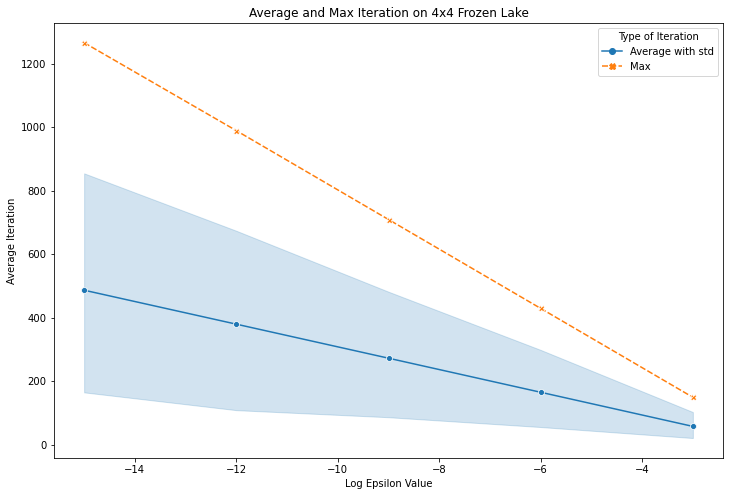

In [18]:
plot_the_dict(vi4[4], value="Iteration", size=4, variable="Log Epsilon Value", log=True)

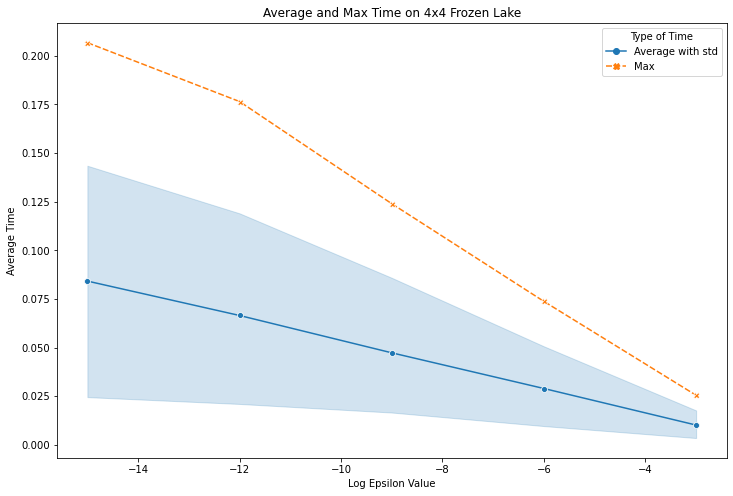

In [19]:
plot_the_dict(vi4[5], value="Time", size=4, variable="Log Epsilon Value", log=True)

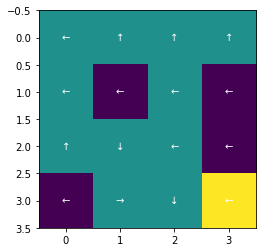

In [20]:
pol = pi_dict[0.99][1e-12]['policy']
pi4 = convert_dict_to_dict(pi_dict)
see_policy(4, pol)

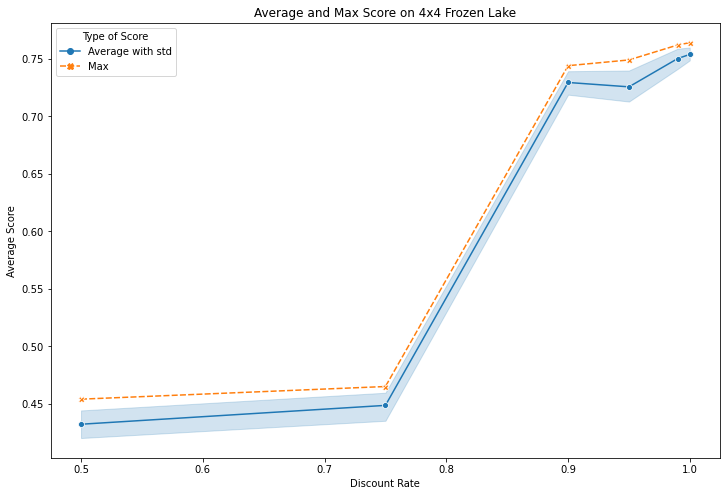

In [21]:
plot_the_dict(pi4[0], value="Score", size=4)

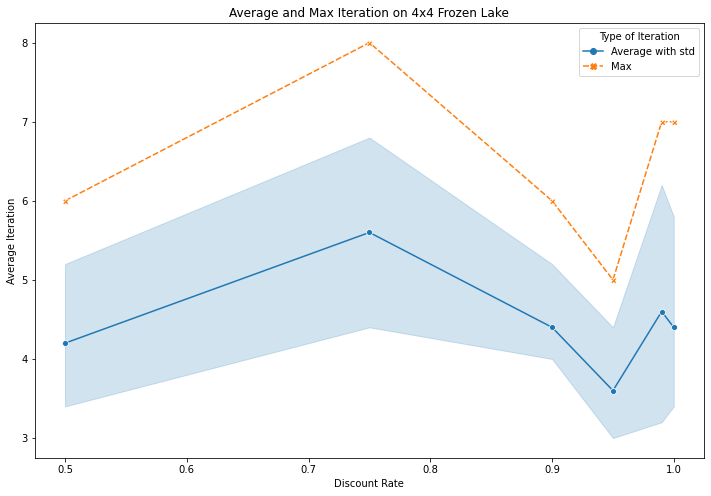

In [22]:
plot_the_dict(pi4[1], value="Iteration", size=4)

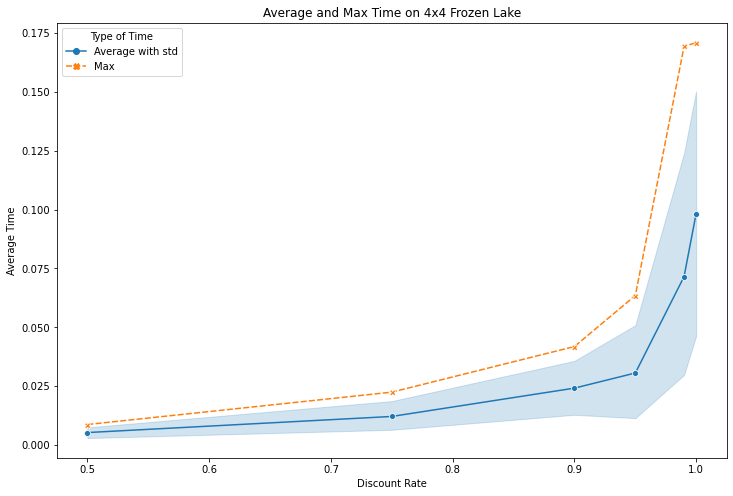

In [23]:
plot_the_dict(pi4[2], value="Time", size=4)

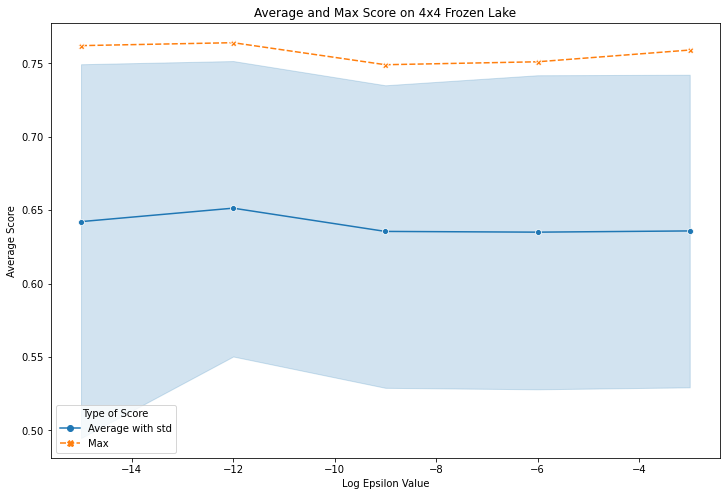

In [24]:
plot_the_dict(pi4[3], value="Score", size=4, variable="Log Epsilon Value", log=True)

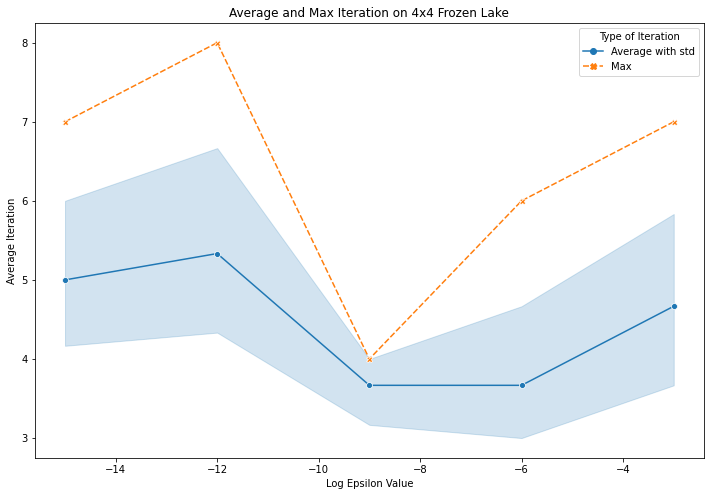

In [25]:
plot_the_dict(pi4[4], value="Iteration", size=4, variable="Log Epsilon Value", log=True)

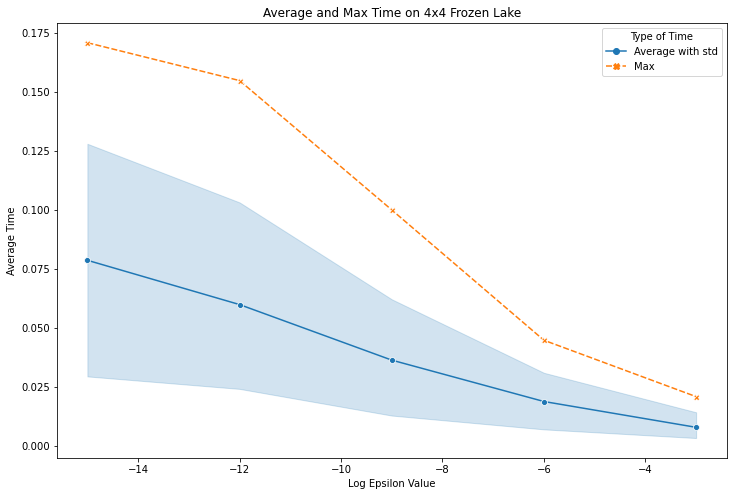

In [26]:
plot_the_dict(pi4[5], value="Time", size=4, variable="Log Epsilon Value", log=True)

## 16 x 16

In [27]:
env = FrozenLakeEnv(desc=MAPS["16x16"])
vi_dict16, pi_dict16 = train_and_test_pi_vi(env, discount=[0.5, 0.75, 0.9, 0.95, 0.99, 0.9999], 
                                          epsilon=[1e-3, 1e-6, 1e-9, 1e-12, 1e-15], mute=True)

Solved in: 7 episodes and 0:00:00.017184 seconds
Solved in: 15 episodes and 0:00:00.031989 seconds
Solved in: 24 episodes and 0:00:00.053720 seconds
Solved in: 34 episodes and 0:00:00.072547 seconds
Solved in: 43 episodes and 0:00:00.097959 seconds
Solved in: 12 episodes and 0:00:00.025815 seconds
Solved in: 31 episodes and 0:00:00.066954 seconds
Solved in: 54 episodes and 0:00:00.121491 seconds
Solved in: 77 episodes and 0:00:00.173841 seconds
Solved in: 100 episodes and 0:00:00.758018 seconds
Solved in: 20 episodes and 0:00:00.044395 seconds
Solved in: 77 episodes and 0:00:00.179607 seconds
Solved in: 138 episodes and 0:00:00.321825 seconds
Solved in: 199 episodes and 0:00:00.481691 seconds
Solved in: 260 episodes and 0:00:00.642089 seconds
Solved in: 31 episodes and 0:00:00.067359 seconds
Solved in: 147 episodes and 0:00:00.341888 seconds
Solved in: 268 episodes and 0:00:00.603029 seconds
Solved in: 384 episodes and 0:00:00.866448 seconds
Solved in: 499 episodes and 0:00:01.181975 s

In [28]:
vi_dict16[0.99]

{0.001: {'mean_reward': 0.367,
  'mean_eps': 213.564,
  'iteration': 93,
  'time_spent': datetime.timedelta(microseconds=225497),
  'policy': array([3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0.,
         0., 0., 2., 2., 2., 2., 2., 3., 3., 3., 3., 2., 2., 1., 1., 1., 3.,
         1., 2., 3., 3., 2., 0., 0., 0., 0., 2., 3., 2., 1., 1., 0., 0., 2.,
         0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 2., 1., 1., 1., 1., 1., 0.,
         0., 1., 2., 1., 3., 0., 0., 1., 1., 2., 1., 1., 1., 1., 1., 3., 1.,
         1., 3., 0., 0., 2., 1., 3., 2., 1., 1., 3., 1., 1., 0., 0., 2., 0.,
         0., 2., 1., 1., 0., 0., 2., 1., 0., 0., 1., 1., 0., 0., 2., 1., 1.,
         1., 3., 3., 2., 1., 1., 1., 3., 1., 1., 1., 1., 1., 2., 2., 2., 0.,
         0., 0., 2., 1., 1., 0., 0., 2., 3., 3., 2., 2., 3., 3., 2., 2., 1.,
         1., 2., 1., 1., 1., 1., 1., 0., 2., 3., 3., 0., 0., 2., 3., 3., 3.,
         2., 2., 1., 0., 3., 3., 1., 3., 0., 0., 2., 1., 0., 0., 0., 0., 2.,
         2., 

In [29]:
pi_dict16[0.9999]

{0.001: {'mean_reward': 0.463,
  'mean_eps': 294.766,
  'iteration': 18,
  'time_spent': datetime.timedelta(microseconds=803029),
  'policy': array([3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2,
         3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 1, 3, 1, 2, 3, 3, 3, 0, 0, 0, 0, 2,
         3, 2, 1, 1, 0, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 1,
         1, 0, 0, 1, 2, 0, 3, 0, 0, 1, 1, 2, 1, 1, 1, 2, 2, 3, 1, 1, 3, 0,
         0, 2, 1, 3, 2, 2, 1, 3, 1, 2, 0, 0, 2, 0, 0, 2, 1, 1, 0, 0, 2, 2,
         0, 0, 1, 2, 0, 0, 2, 2, 1, 2, 3, 3, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1,
         2, 2, 2, 0, 0, 0, 2, 2, 1, 0, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
         2, 2, 1, 1, 1, 1, 0, 2, 3, 3, 0, 0, 2, 3, 3, 3, 2, 2, 2, 1, 3, 3,
         1, 3, 0, 0, 2, 1, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 3, 3, 3, 0, 0, 0,
         0, 1, 2, 1, 2, 3, 3, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 2, 2, 0, 0,
         0, 2, 0, 0, 1, 1, 1, 0, 0, 2, 3, 1, 2, 2, 0, 0, 0, 2, 0, 0, 1, 1,
         1, 1, 1, 0, 0, 2, 2, 2, 0,

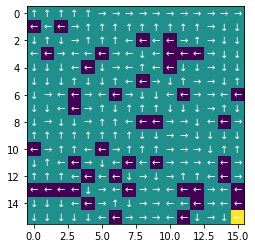

In [30]:
pol = vi_dict16[0.9999][1e-15]['policy']
vi16 = convert_dict_to_dict(vi_dict16)
see_policy(16, pol)

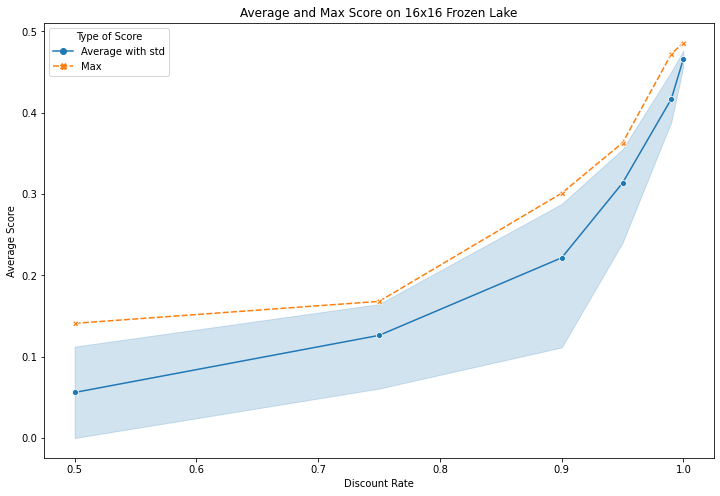

In [31]:
plot_the_dict(vi16[0], value="Score", size=16)

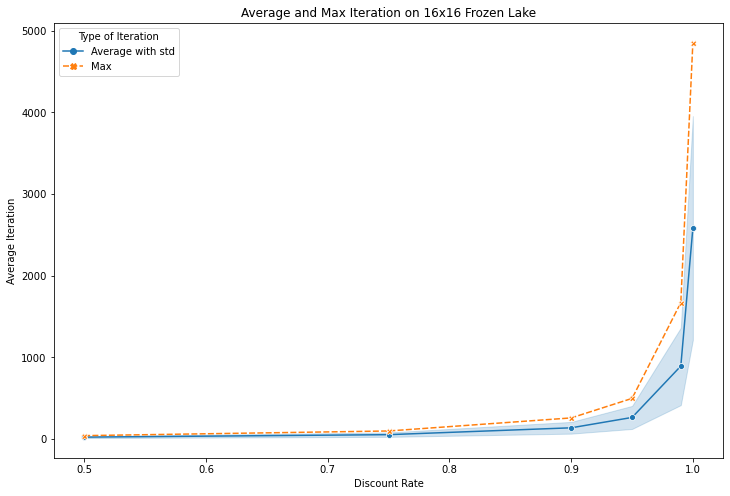

In [32]:
plot_the_dict(vi16[1], value="Iteration", size=16)

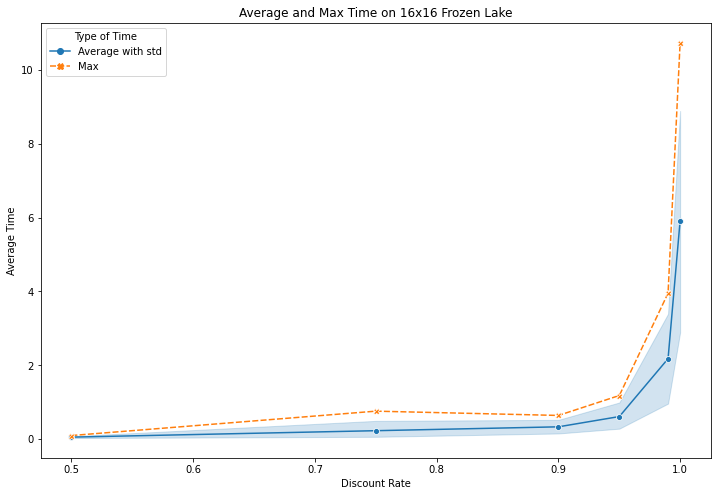

In [33]:
plot_the_dict(vi16[2], value="Time", size=16)

In [34]:
pi16 = convert_dict_to_dict(pi_dict16)

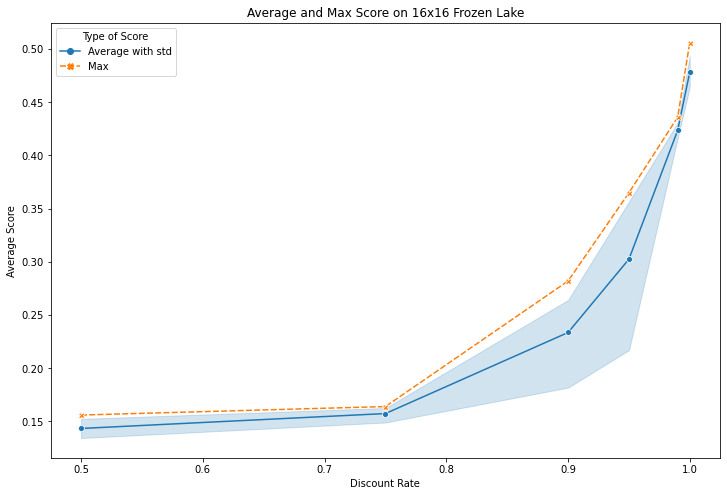

In [35]:
plot_the_dict(pi16[0], value="Score", size=16)

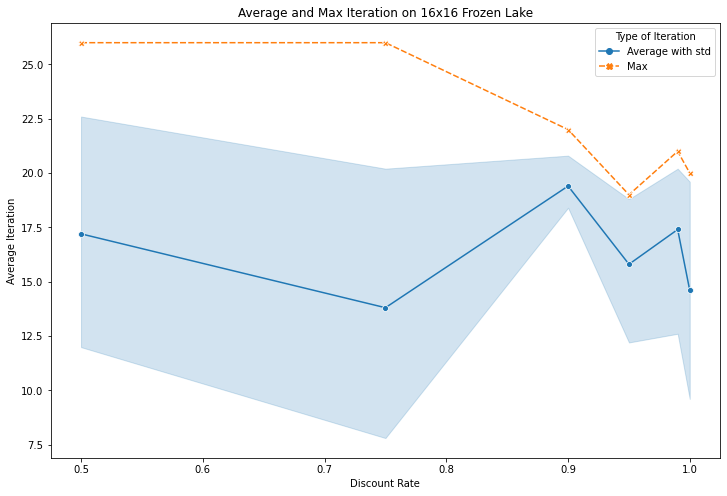

In [36]:
plot_the_dict(pi16[1], value="Iteration", size=16)

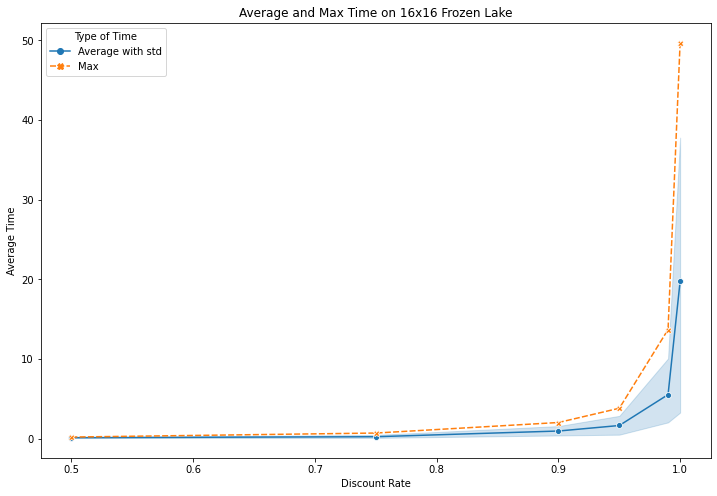

In [37]:
plot_the_dict(pi16[2], value="Time", size=16)

In [38]:
import dill
dill.dump_session('vi_pi_all.db')

### REINFORCEMENT LEARNING APPROACH

#### Q_LEARNING

In [39]:
import gym
import numpy as np
import random
from timeit import default_timer as timer
from datetime import timedelta
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns

In [40]:
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
np.random.seed(44)
sixteen = generate_random_map(16)
np.random.seed(44)
tvelve = generate_random_map(12)
MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
    "12x12": tvelve,
    "16x16": sixteen
}

In [41]:
def test_policy(env, policy, n_epoch=1000):
    rewards = []
    episode_counts = []
    for i in range(n_epoch):
        current_state = env.reset()
        ep = 0
        done = False
        episode_reward = 0
        while not done and ep < 10000:
            ep += 1
            act = int(policy[current_state])
            new_state, reward, done, _ = env.step(act)
            episode_reward += reward
            current_state = new_state
        rewards.append(episode_reward)
        episode_counts.append(ep)
    
    # all done
    mean_reward = sum(rewards)/len(rewards)
    mean_eps = sum(episode_counts)/len(episode_counts)
    return mean_reward, mean_eps, rewards, episode_counts 

In [42]:
def q_learning(env, discount=0.9, total_episodes=1e5, alpha=0.1, decay_rate=None,
               min_epsilon=0.01):
    
    start = timer()
    
    number_of_states = env.observation_space.n
    number_of_actions = env.action_space.n
    
    qtable = np.zeros((number_of_states, number_of_actions))
    learning_rate = alpha
    gamma = discount

    # exploration parameter
    epsilon = 1.0
    max_epsilon = 1.0
    min_epsilon = 0.01
    
    if not decay_rate:
        decay_rate = 1./total_episodes
    
    rewards = []
    for episode in range(int(total_episodes)):
        # reset the environment
        state = env.reset()
        step = 0
        done = False
        total_reward = 0
        while True:

            # choose an action a in the corrent world state
            exp_exp_tradeoff = random.uniform(0,1)

            # if greater than epsilon --> exploit
            if exp_exp_tradeoff > epsilon:
                b = qtable[state, :]
                action = np.random.choice(np.where(b == b.max())[0])
#                 action = np.argmax(qtable[state, :])
            # else choose exploration
            else:
                action = env.action_space.sample()

            # take action (a) and observe the outcome state (s') and reward (r)    
            new_state, reward, done, info = env.step(action)
            total_reward += reward
            # update Q(s,a) := Q(s,a) + lr [R(s,a) + gamma * max(Q (s', a') - Q(s,a))]
            if not done:
                qtable[state, action] = qtable[state, action] + learning_rate*(reward + gamma*np.max(qtable[new_state, :]) - qtable[state, action])
            else:
                qtable[state, action] = qtable[state,action] + learning_rate*(reward - qtable[state,action])

            # change state
            state = new_state

            # is it Done
            if done:
                break
                
        # reduce epsilon 
        rewards.append(total_reward)
        epsilon = max(max_epsilon -  decay_rate * episode, min_epsilon) 
    #     print (epsilon)
    
    end = timer()
    time_spent = timedelta(seconds=end-start)
    print("Solved in: {} episodes and {} seconds".format(total_episodes, time_spent))
    return np.argmax(qtable, axis=1), total_episodes, time_spent, qtable, rewards

In [43]:
def train_and_test_q_learning(env, discount=[0.9], total_episodes=[1e5], alphas=[0.1], decay_rates=[0.01], mute=False):
    
    min_epsilon = 0.01
    
    q_dict = {}
    for dis in discount:
        q_dict[dis] = {}
        for eps in total_episodes:
            q_dict[dis][eps] = {}
            for alpha in alphas:
                q_dict[dis][eps][alpha] = {}
                for dr in decay_rates:
                    q_dict[dis][eps][alpha][dr] = {}
                    
                    # run q_learning
                    q_policy, q_solve_iter, q_solve_time, q_table, rewards = q_learning(env, dis, eps, alpha, dr, min_epsilon)
                    q_mrews, q_meps, _, __ = test_policy(env, q_policy)
                    q_dict[dis][eps][alpha][dr]["mean_reward"] = q_mrews
                    q_dict[dis][eps][alpha][dr]["mean_eps"] = q_meps
                    q_dict[dis][eps][alpha][dr]["q-table"] = q_table
                    q_dict[dis][eps][alpha][dr]["rewards"] = rewards 
                    q_dict[dis][eps][alpha][dr]["iteration"] = q_solve_iter
                    q_dict[dis][eps][alpha][dr]["time_spent"] = q_solve_time
                    q_dict[dis][eps][alpha][dr]["policy"] = q_policy
                    if not mute:
                        print("gamma: {} total_eps: {} lr: {}, dr: {}".format(dis, eps, alpha, dr))
                        print("Iteration: {} time: {}".format(q_solve_iter, q_solve_time))
                        print("Mean reward: {} - mean eps: {}".format(q_mrews, q_meps))
    return q_dict

In [44]:
def map_discretize(the_map):
    size = len(the_map)
    dis_map = np.zeros((size,size))
    for i, row in enumerate(the_map):
        for j, loc in enumerate(row):
            if loc == "S":
                dis_map[i, j] = 0
            elif loc == "F":
                dis_map[i, j] = 0
            elif loc == "H":
                dis_map[i, j] = -1
            elif loc == "G":
                dis_map[i, j] = 1
    return dis_map


def policy_numpy(policy):
    size = int(np.sqrt(len(policy)))
    pol = np.asarray(policy)
    pol = pol.reshape((size, size))
    return pol


def see_policy(map_size, policy):
    map_name = str(map_size)+"x"+str(map_size)
    data = map_discretize(MAPS[map_name])
    np_pol = policy_numpy(policy)
    plt.imshow(data, interpolation="nearest")

    for i in range(np_pol[0].size):
        for j in range(np_pol[0].size):
            arrow = '\u2190'
            if np_pol[i, j] == 1:
                arrow = '\u2193'
            elif np_pol[i, j] == 2:
                arrow = '\u2192'
            elif np_pol[i, j] == 3:
                arrow = '\u2191'
            text = plt.text(j, i, arrow,
                           ha="center", va="center", color="w")
    plt.show()


In [45]:
def dict_to_df(the_dict):
    the_df = pd.DataFrame(columns=["Discount Rate", "Training Episodes", "Learning Rate", 
                                   "Decay Rate", "Reward", "Time Spent"])
    for dis in the_dict:
        for eps in the_dict[dis]:
            for lr in the_dict[dis][eps]:
                for dr in the_dict[dis][eps][lr]:
                    rew = the_dict[dis][eps][lr][dr]["mean_reward"]
                    time_spent = the_dict[dis][eps][lr][dr]["time_spent"].total_seconds()
                    dic = {"Discount Rate": dis, "Training Episodes": eps, "Learning Rate":lr, 
                           "Decay Rate":dr, "Reward": rew, "Time Spent": time_spent}
                    the_df = the_df.append(dic, ignore_index=True)
    return the_df

In [46]:
import numpy as np
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [47]:
env = gym.make('FrozenLake-v1')
episodes = [1e4, 1e5, 1e6]
decays = [1e-6]

q_dict = train_and_test_q_learning(env, discount=[0.75, 0.9, 0.99, 0.9999], total_episodes=episodes,
                          alphas=[0.01, 0.1], decay_rates=decays)

Solved in: 10000.0 episodes and 0:00:01.621588 seconds
gamma: 0.75 total_eps: 10000.0 lr: 0.01, dr: 1e-06
Iteration: 10000.0 time: 0:00:01.621588
Mean reward: 0.27 - mean eps: 23.591
Solved in: 10000.0 episodes and 0:00:01.689444 seconds
gamma: 0.75 total_eps: 10000.0 lr: 0.1, dr: 1e-06
Iteration: 10000.0 time: 0:00:01.689444
Mean reward: 0.179 - mean eps: 14.544
Solved in: 100000.0 episodes and 0:00:16.156713 seconds
gamma: 0.75 total_eps: 100000.0 lr: 0.01, dr: 1e-06
Iteration: 100000.0 time: 0:00:16.156713
Mean reward: 0.462 - mean eps: 27.564
Solved in: 100000.0 episodes and 0:00:15.952029 seconds
gamma: 0.75 total_eps: 100000.0 lr: 0.1, dr: 1e-06
Iteration: 100000.0 time: 0:00:15.952029
Mean reward: 0.127 - mean eps: 8.07
Solved in: 1000000.0 episodes and 0:05:13.880276 seconds
gamma: 0.75 total_eps: 1000000.0 lr: 0.01, dr: 1e-06
Iteration: 1000000.0 time: 0:05:13.880276
Mean reward: 0.44 - mean eps: 28.066
Solved in: 1000000.0 episodes and 0:04:20.560974 seconds
gamma: 0.75 total

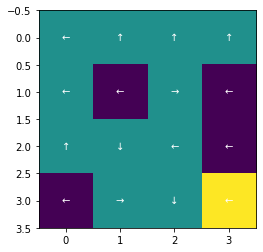

In [48]:
pol = q_dict[0.99][int(1e6)][0.1][1e-06]['policy']
see_policy(4, pol)

In [49]:
episodes = [1e4, 1e5, 1e6]
decays = [1e-3, 1e-5]
q_dict = train_and_test_q_learning(env, discount= [0.9999], total_episodes=episodes,
                          alphas=[0.1, 0.01], decay_rates=decays)

Solved in: 10000.0 episodes and 0:00:10.775222 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.1, dr: 0.001
Iteration: 10000.0 time: 0:00:10.775222
Mean reward: 0.737 - mean eps: 41.054
Solved in: 10000.0 episodes and 0:00:02.007059 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.1, dr: 1e-05
Iteration: 10000.0 time: 0:00:02.007059
Mean reward: 0.604 - mean eps: 47.159
Solved in: 10000.0 episodes and 0:00:02.706010 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.01, dr: 0.001
Iteration: 10000.0 time: 0:00:02.706010
Mean reward: 0.045 - mean eps: 8.084
Solved in: 10000.0 episodes and 0:00:02.052353 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.01, dr: 1e-05
Iteration: 10000.0 time: 0:00:02.052353
Mean reward: 0.748 - mean eps: 41.356
Solved in: 100000.0 episodes and 0:02:04.239982 seconds
gamma: 0.9999 total_eps: 100000.0 lr: 0.1, dr: 0.001
Iteration: 100000.0 time: 0:02:04.239982
Mean reward: 0.717 - mean eps: 45.325
Solved in: 100000.0 episodes and 0:00:44.907969 seconds
gamma: 0.9999 t

/Users/cindynyoumsi/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

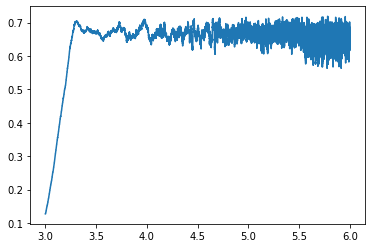

In [50]:
rews = q_dict[0.9999][int(1e6)][0.1][1e-03]['rewards']
run = 1000
rew_running = running_mean(rews, run)
indices = [i+run for i in list(range(len(rew_running)))]
sns.lineplot(np.log10(indices), rew_running)

/Users/cindynyoumsi/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

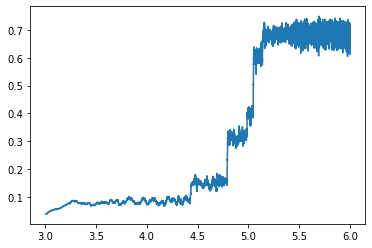

In [51]:
rews = q_dict[0.9999][int(1e6)][0.01][1e-03]['rewards']
run = 1000
rew_running = running_mean(rews, run)
indices = [i+run for i in list(range(len(rew_running)))]
sns.lineplot(np.log10(indices), rew_running)

/Users/cindynyoumsi/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

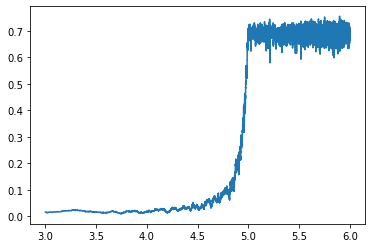

In [52]:
rews = q_dict[0.9999][int(1e6)][0.01][1e-05]['rewards']
run = 1000
rew_running = running_mean(rews, run)
indices = [i+run for i in list(range(len(rew_running)))]
sns.lineplot(np.log10(indices), rew_running)

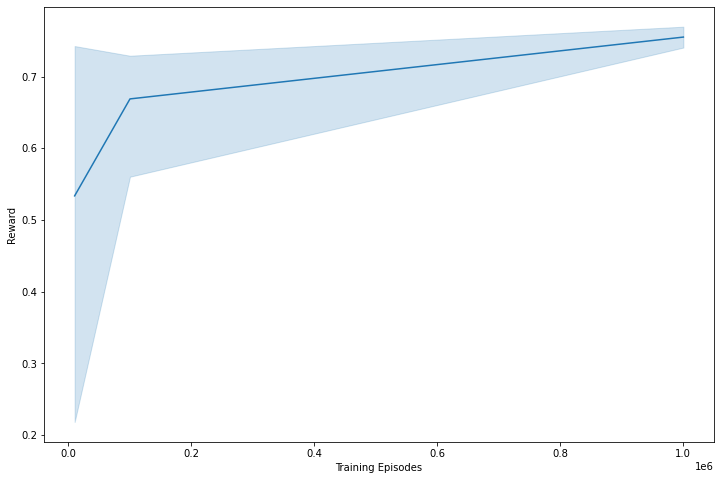

In [53]:
q4 = dict_to_df(q_dict)
# plt.figure(figsize=(12, 8))
pl = sns.lineplot(x="Training Episodes", y="Reward", data=q4)
pl.figure.set_figwidth(12)
pl.figure.set_figheight(8)

In [63]:
q4

,Discount Rate,Training Episodes,Learning Rate,Decay Rate,Reward,Time Spent
0,0.9999,10000.0,0.10,0.00100,0.737,10.775222
1,0.9999,10000.0,0.10,0.00001,0.604,2.007059
2,0.9999,10000.0,0.01,0.00100,0.045,2.706010
3,0.9999,10000.0,0.01,0.00001,0.748,2.052353
4,0.9999,100000.0,0.10,0.00100,0.717,124.239982
5,0.9999,100000.0,0.10,0.00001,0.733,44.907969
6,0.9999,100000.0,0.01,0.00100,0.508,55.784559
7,0.9999,100000.0,0.01,0.00001,0.717,43.354927
8,0.9999,1000000.0,0.10,0.00100,0.766,4116.382169
9,0.9999,1000000.0,0.10,0.00001,0.748,1233.478010


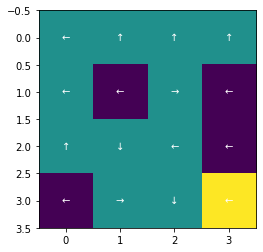

In [55]:
pol = q_dict[0.9999][int(1e6)][0.01][1e-03]['policy']
see_policy(4, pol)

## 16x16

In [56]:
env = FrozenLakeEnv(desc=MAPS["16x16"])
episodes = [1e4, 1e5, 1e6]
decays = [1e-3, 1e-5]
q_dict16 = train_and_test_q_learning(env, discount= [0.9999], total_episodes=episodes,
                          alphas=[0.1, 0.01], decay_rates=decays)

Solved in: 10000.0 episodes and 0:00:01.454109 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.1, dr: 0.001
Iteration: 10000.0 time: 0:00:01.454109
Mean reward: 0.0 - mean eps: 3.054
Solved in: 10000.0 episodes and 0:00:01.187947 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.1, dr: 1e-05
Iteration: 10000.0 time: 0:00:01.187947
Mean reward: 0.0 - mean eps: 2.969
Solved in: 10000.0 episodes and 0:00:01.677801 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.01, dr: 0.001
Iteration: 10000.0 time: 0:00:01.677801
Mean reward: 0.0 - mean eps: 3.122
Solved in: 10000.0 episodes and 0:00:01.327828 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.01, dr: 1e-05
Iteration: 10000.0 time: 0:00:01.327828
Mean reward: 0.0 - mean eps: 3.054
Solved in: 100000.0 episodes and 0:00:15.551085 seconds
gamma: 0.9999 total_eps: 100000.0 lr: 0.1, dr: 0.001
Iteration: 100000.0 time: 0:00:15.551085
Mean reward: 0.0 - mean eps: 2.966
Solved in: 100000.0 episodes and 0:00:12.811700 seconds
gamma: 0.9999 total_eps: 1000

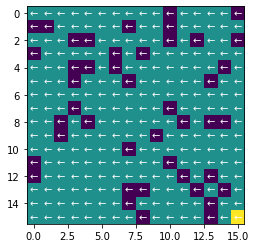

In [57]:
pol = q_dict16[0.9999][int(1e6)][0.1][1e-05]['policy']
see_policy(16, pol)

In [58]:
(q_dict16[0.9999][int(1e6)][0.1][1e-05]['q-table'] > 0).any()

False

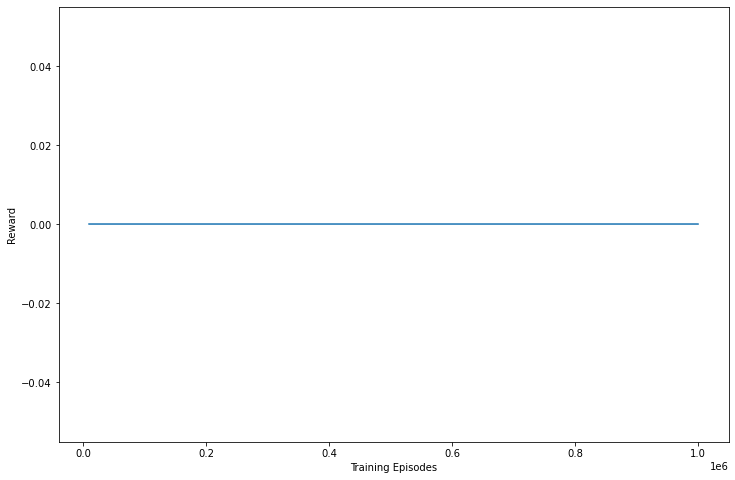

In [60]:
q16 = dict_to_df(q_dict16)
p2 = sns.lineplot(x="Training Episodes", y="Reward", data=q16)
p2.figure.set_figwidth(12)
p2.figure.set_figheight(8)

In [62]:
q16

,Discount Rate,Training Episodes,Learning Rate,Decay Rate,Reward,Time Spent
0,0.9999,10000.0,0.10,0.00100,0.0,1.454109
1,0.9999,10000.0,0.10,0.00001,0.0,1.187947
2,0.9999,10000.0,0.01,0.00100,0.0,1.677801
3,0.9999,10000.0,0.01,0.00001,0.0,1.327828
4,0.9999,100000.0,0.10,0.00100,0.0,15.551085
5,0.9999,100000.0,0.10,0.00001,0.0,12.811700
6,0.9999,100000.0,0.01,0.00100,0.0,15.650100
7,0.9999,100000.0,0.01,0.00001,0.0,12.539433
8,0.9999,1000000.0,0.10,0.00100,0.0,140.076092
9,0.9999,1000000.0,0.10,0.00001,0.0,137.207483
